<a href="https://colab.research.google.com/github/TemaPython/Product-Analyst-Projects/blob/main/Marketing_AB_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Проект по анализу A/B тестирования**

## **Описание данных**

**marketing_AB.csv**  взаимодействие пользователей с рекламой

Структура файла:
* user_id - id пользователя;
* test_group - группа тестирования (ad - группа, видящая рекламу, psa - группа, не видящая рекламу);
* converted - покупка продукта;
* total ads - количество реклламы, показанное пользователю
* most ads day - день максимального количество рекламы
* most ads hour - час максимального количества рекламы

## **Постановка задачи**
Задача — провести оценку результатов A/B-теста. В распоряжении есть датасет с конверсией покупок.

1. Оценить успешность рекламной компании
2. Если компания успешна, то насколько повлияло количество показанной рекламы на конверсию

## **Загрузка и обработка данных**

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from statsmodels.stats.proportion import proportions_ztest

In [2]:
import kagglehub

path = kagglehub.dataset_download("faviovaz/marketing-ab-testing")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'marketing-ab-testing' dataset.
Path to dataset files: /kaggle/input/marketing-ab-testing


In [11]:
try:
    ab_test = pd.read_csv("/root/.cache/kagglehub/datasets/"
    "faviovaz/marketing-ab-testing/versions/1/marketing_AB.csv",
                          index_col="Unnamed: 0")
except:
    print("Файл не найден")

In [13]:
ab_test.head()

,user id,test group,converted,total ads,most ads day,most ads hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14


In [15]:
def review(table):
    print("Информация")
    print(table.info())
    print("Описание")
    print(table.describe())
    print("Количество пропусков")
    print(table.isna().sum())
    print("Количество повторений")
    print(table.duplicated().sum())

In [16]:
review(ab_test)

Информация
<class 'pandas.core.frame.DataFrame'>
Index: 588101 entries, 0 to 588100
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   user id        588101 non-null  int64 
 1   test group     588101 non-null  object
 2   converted      588101 non-null  bool  
 3   total ads      588101 non-null  int64 
 4   most ads day   588101 non-null  object
 5   most ads hour  588101 non-null  int64 
dtypes: bool(1), int64(3), object(2)
memory usage: 27.5+ MB
None
Описание
            user id      total ads  most ads hour
count  5.881010e+05  588101.000000  588101.000000
mean   1.310692e+06      24.820876      14.469061
std    2.022260e+05      43.715181       4.834634
min    9.000000e+05       1.000000       0.000000
25%    1.143190e+06       4.000000      11.000000
50%    1.313725e+06      13.000000      14.000000
75%    1.484088e+06      27.000000      18.000000
max    1.654483e+06    2065.000000      23.000000
Количест

### Вывод:


1.   Приводить типы данных не требуется
2.   Пропусков и повторений нет



## **Обработка данных**

In [29]:
ab_test

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14
...,...,...,...,...,...,...
588096,1278437,ad,False,1,Tuesday,23
588097,1327975,ad,False,1,Tuesday,23
588098,1038442,ad,False,3,Tuesday,23
588099,1496395,ad,False,1,Tuesday,23


In [28]:
ab_test.columns = ['user_id', 'test_group', 'converted', 'total_ads',
                   'most_ads_day', 'most_ads_hour']

In [61]:
group_converted = ab_test.groupby(by="test_group").agg({"user_id" : "nunique",
                                      "converted" : "sum"})
ad_p = round(group_converted.iloc[0, 0]/group_converted.iloc[:, 0].sum()*100,1)
psa_p = round(group_converted.iloc[1, 0]/group_converted.iloc[:, 0].sum()*100,1)
print(f"Разделение групп ad к psa {ad_p}% к {psa_p}%")

Разделение групп ad к psa 96.0% к 4.0%


In [46]:
group_converted["conv_perc"] = group_converted["converted"]/ \
                                group_converted["user_id"] * 100
group_converted

,user_id,converted,conv_perc
test_group,,,
ad,564577,14423,2.554656
psa,23524,420,1.785411


### **Проверка статистической разницы долей z-критерием**


Нулевая гипотеза: рекламная компания не повлияла на продажи
Альтернативная гипотеза: рекламная компания увеличила конверсию покупок

In [104]:
conversions = group_converted["converted"].tolist()
nobs = group_converted["user_id"].tolist()
z_stat, p_value = proportions_ztest(conversions, nobs)
print(f"Z-статистика: {z_stat:.4f}")
print(f"p-value: {p_value:.18f}")

Z-статистика: 7.3701
p-value: 0.000000000000170528


Вывод:

1. Группы были поделены не равномерно, а как 96% к 4%, поэтому надо смотреть относительные значения
2. По результатам рекламной компании у эксперементальной группы конверсия 2.55% к 1.79%. Различия довольно большие, но стоит исследовать влияние количества показанной рекламы
3. Полученное значение Z-статистики 7.37 больше критического 1.96, а p-value стремится к нулю. Значит наша рекламная компания имеет довольно высокую эффективность. Альтернативная гипотеза верна


## **Зависимость конверсии от количества рекламы**

In [76]:
ad_count = ab_test[ab_test["test_group"] == "ad"].loc[:,
                                ["converted", "total_ads"]]
x_values = pd.Series(range(0,len(ad_count['total_ads'])))

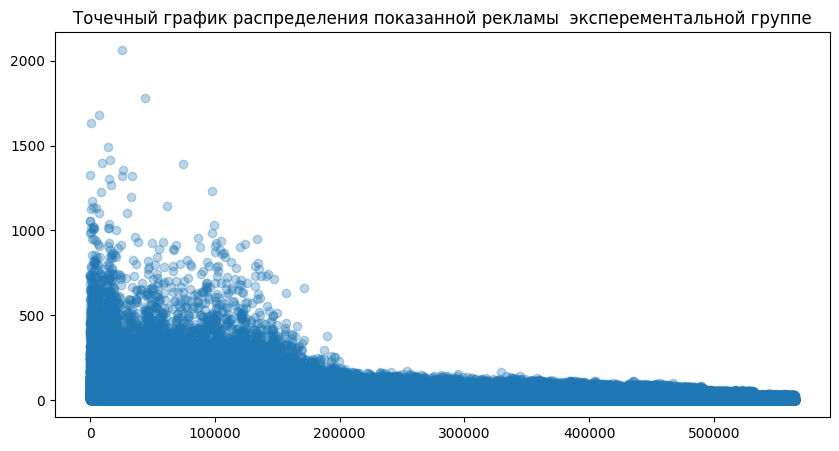

In [78]:
plt.figure(figsize=(10,5))
plt.scatter(x_values, ad_count["total_ads"], alpha=0.3)
plt.title("Точечный график распределения показанной рекламы \
 эксперементальной группе")
plt.show()

In [98]:
print(np.percentile(ad_count['total_ads'], [95, 99]))

[ 87. 201.]


In [89]:
bins = [0, 5, 10, 20, 50, 100, 200, 500, 2500]
labels = ['1-5', '6-10', '11-20', '21-50', '51-100', '101-200', '201-500', '500+']
ad_count['ads_tier'] = pd.cut(ad_count['total_ads'], bins=bins, labels=labels)
tier_conv = ad_count.groupby(by="ads_tier", observed=False)["converted"].mean() * 100
tier_conv

,converted
ads_tier,
1-5,0.251233
6-10,0.485309
11-20,0.839995
21-50,2.915382
51-100,11.631068
101-200,17.677262
201-500,15.366615
500+,17.491166


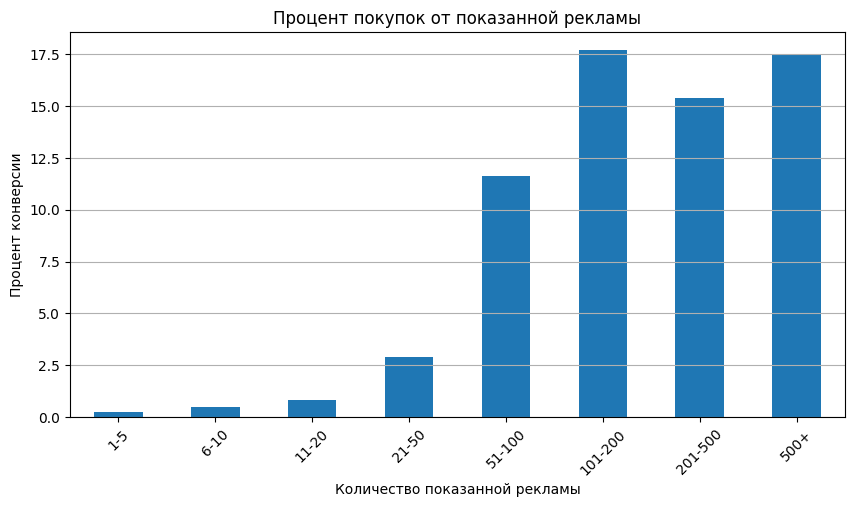

In [97]:
plt.figure(figsize=(10, 5))
tier_conv.plot(kind='bar')
plt.title("Процент покупок от показанной рекламы")
plt.xlabel("Количество показанной рекламы")
plt.ylabel("Процент конверсии")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

Вывод:

1. Менее 5% пользователей увидело более 100 рекламных объвлений
2. Чем больше рекламы было, показанно человеку, тем больше конверсия. Ощутимый прирост начинается от 50 показов
3. Уже на показе от 20 до 50 объявлений получаем процент конверсии больше, чем в выборке, не видящей рекламу

## **Зависимость от времени и дня**

In [109]:
time_test = ab_test[ab_test["test_group"] == "ad"]

In [111]:
time_test

,user_id,test_group,converted,total_ads,most_ads_day,most_ads_hour
0,1069124,ad,False,130,Monday,20
1,1119715,ad,False,93,Tuesday,22
2,1144181,ad,False,21,Tuesday,18
3,1435133,ad,False,355,Tuesday,10
4,1015700,ad,False,276,Friday,14
...,...,...,...,...,...,...
588096,1278437,ad,False,1,Tuesday,23
588097,1327975,ad,False,1,Tuesday,23
588098,1038442,ad,False,3,Tuesday,23
588099,1496395,ad,False,1,Tuesday,23


In [114]:
days_test = time_test.groupby(by="most_ads_day")["converted"].mean() * 100

In [118]:
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
              'Friday', 'Saturday', 'Sunday']
days_test_sorted = days_test.reindex(days_order)
days_test_sorted

,converted
most_ads_day,
Monday,3.324120
Tuesday,3.044038
Wednesday,2.535586
Thursday,2.163714
Friday,2.246495
Saturday,2.130657
Sunday,2.461983


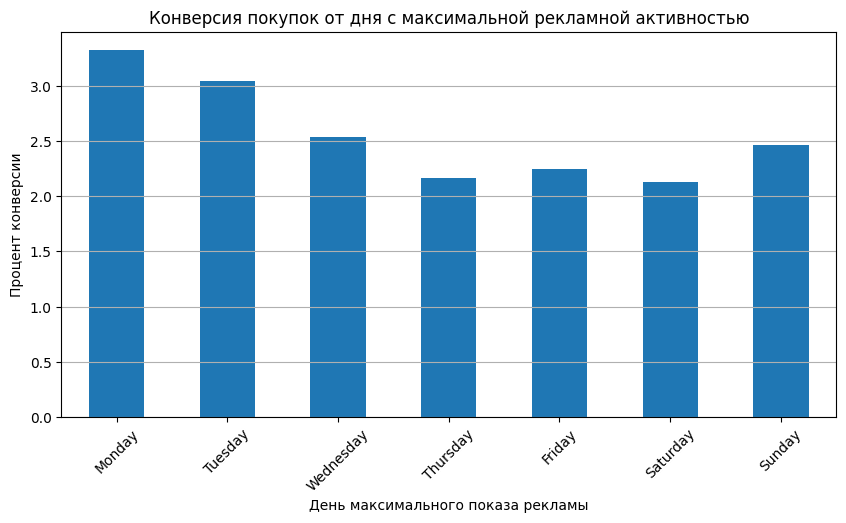

In [120]:
plt.figure(figsize=(10, 5))
days_test_sorted.plot(kind='bar')
plt.title("Конверсия покупок от дня с максимальной рекламной активностью")
plt.xlabel("День максимального показа рекламы")
plt.ylabel("Процент конверсии")
plt.grid(axis='y')
plt.xticks(rotation=45)
plt.show()

In [123]:
hour_test = time_test.groupby(by="most_ads_hour")["converted"].mean() * 100
hour_test

,converted
most_ads_hour,
0,1.921266
1,1.343445
2,0.756988
3,1.042471
4,1.585014
5,2.156334
6,2.317380
7,1.848249
8,1.986091


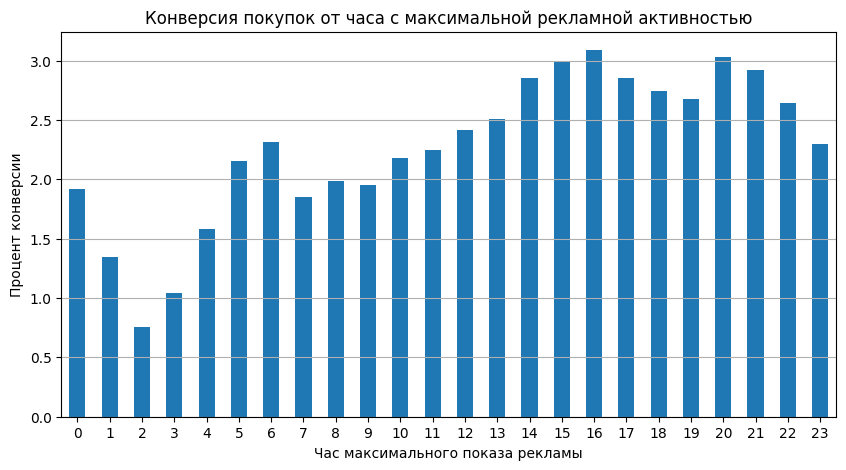

In [144]:
plt.figure(figsize=(10, 5))
hour_test.plot(kind='bar')
plt.title("Конверсия покупок от часа с максимальной рекламной активностью")
plt.xlabel("Час максимального показа рекламы")
plt.ylabel("Процент конверсии")
plt.grid(axis='y')
plt.xticks(rotation=0)
plt.show()

In [134]:
hour_day_test = time_test.groupby(by=["most_ads_day","most_ads_hour"])\
 ["converted"].mean().sort_values(ascending=False) * 100

In [138]:
hour_day_test[hour_day_test > 4]

most_ads_day  most_ads_hour
Saturday      5                5.681818
              6                5.158730
Tuesday       16               4.557641
Monday        14               4.487498
Sunday        20               4.366461
Monday        15               4.294479
              6                4.198473
Tuesday       15               4.119519
Name: converted, dtype: float64

Вывод:

1. В понедельник и вторник была самая большая конверсия
2. По времени оказалось совершшенно невыгодно показывать рекламу с 1:00 до 5:00
3. Были выделены самые приоритетные дни со временем для показа рекламы
4. Стоит учитывать, что мы не можем быть уверенны, что на совершение покупки повлияла реклама именно в момент наибольшего показа. Вполне вероятно пользователь клинкул на рекламное объвление в другое время и совершил покупку

## **Общий вывод**

1. Выяснили с довольно большой точностью, что нулевая гипотеза неверна и рекламная компания увеличила конверсию покупок. Был использован Z-тест. p-value получилось крайне близким к нулю

2. Чем больше рекламы было показано пользователю, тем с большим шансом он приобретет товар. Ощутимый прирост конверсии начинается при показе более 50 рекламных объявллений

3. Была проанализирована конверсия покупок от дня и часа максимального показа рекламы. По результатам теста, стоит показывать больше рекламы в понедельник и вторник. Также не стоит особо показывать рекламу в период с часу ночи до четырех утра. Такжже были выделены наиболее эффективные промежутки времени для показа рекламы. <br> (Понедельник 14:00 - 16:00, <br> Вторник 15:00 - 16:00, <br> Суббота 5:00 - 7:00, <br> Воскресенье 20:00 - 21:00)

Тест вероятнее всего был проведен корректно и его результаты можно использовать для дальнейшего проведения рекламной компании. Однако к выводам, с деланным из времени показза рекламы стоит относиться с осторожностью. Тут имеют место быть сторонние факторы, например праздничные дни